In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode
from pyspark.sql.types import IntegerType

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Voter Data Analysis").getOrCreate()

# Read data and some basic informaiton about data

In [2]:
# load AZ data
bucket_dir="gs://pstat135-voter-file/VM2Uniform/"
df = spark.read.parquet(bucket_dir + 'VM2Uniform--AZ--2021-05-20')

In [3]:
# the total records output
df.count()

4266400

In [4]:
df.printSchema()

root
 |-- SEQUENCE: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_StateVoterID: string (nullable = true)
 |-- Voters_CountyVoterID: string (nullable = true)
 |-- VoterTelephones_LandlineAreaCode: string (nullable = true)
 |-- VoterTelephones_Landline7Digit: string (nullable = true)
 |-- VoterTelephones_LandlineFormatted: string (nullable = true)
 |-- VoterTelephones_LandlineUnformatted: string (nullable = true)
 |-- VoterTelephones_LandlineConfidenceCode: string (nullable = true)
 |-- VoterTelephones_CellPhoneOnly: string (nullable = true)
 |-- VoterTelephones_CellPhoneFormatted: string (nullable = true)
 |-- VoterTelephones_CellPhoneUnformatted: string (nullable = true)
 |-- VoterTelephones_CellConfidenceCode: string (nullable = true)
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_MiddleName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- Voters_NameSuffix: string (

In [5]:
# select some variables we are interested in from the data
df_need = df.select("Voters_Age",
                    "Voters_Gender",
                    "CommercialData_EstimatedHHIncomeAmount", 
                    "CommercialData_EstHomeValue",
                    "FECDonors_TotalDonationsAmount",
                    "CommercialData_Education",
                    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
df_need.show(10)

+----------+-------------+--------------------------------------+---------------------------+------------------------------+------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|FECDonors_TotalDonationsAmount|CommercialData_Education|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+----------+-------------+--------------------------------------+---------------------------+------------------------------+------------------------+---------------------------------------------------+
|        96|            F|                                  null|                       null|                          null|                    null|                                                55%|
|        68|            M|                                  null|                       null|                          null|                    null|                                           

## Turnout rate

In [7]:
# drop Null values and show statistical description 
turnout_df = df_need.select("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
turnout_df = turnout_df.withColumn(
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters", 
    regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType())
)

turnout_df.describe(["ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]).show()

+-------+---------------------------------------------------+
|summary|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+-------+---------------------------------------------------+
|  count|                                            4266400|
|   mean|                                  67.87103858053628|
| stddev|                                 4.8104021587435435|
|    min|                                                 53|
|    max|                                                 76|
+-------+---------------------------------------------------+



Text(0, 0.5, 'Frequency')

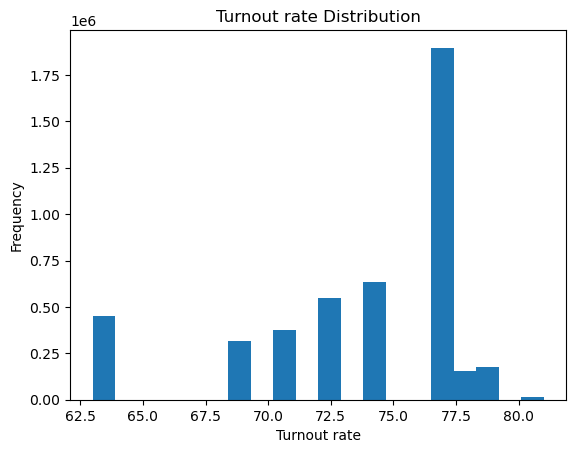

In [7]:
# Plot its distribution
data = turnout_df.sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").toPandas()
plt.hist(data, bins=20)
plt.title('Turnout rate Distribution')
plt.xlabel('Turnout rate')
plt.ylabel('Frequency')

## Age

In [8]:
# drop Null values and show statistical description 
age_df = df_need.select("Voters_Age").na.drop()
age_df.describe(["Voters_Age"]).show()

+-------+------------------+
|summary|        Voters_Age|
+-------+------------------+
|  count|           4569645|
|   mean| 50.39094940635432|
| stddev|18.747003571724626|
|    min|                19|
|    max|               100|
+-------+------------------+



Text(0, 0.5, 'Frequency')

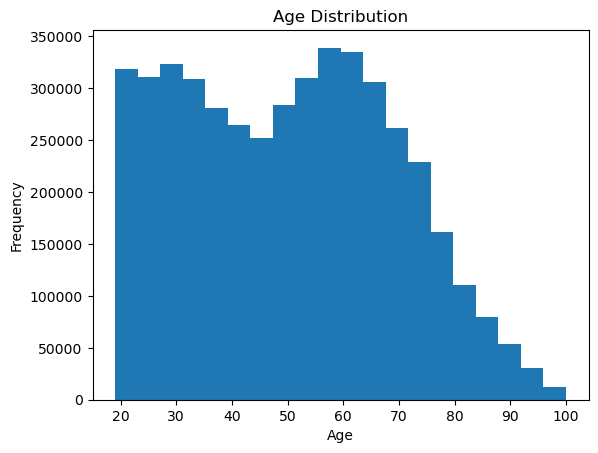

In [9]:
# Plot its distribution
data = age_df.sort("Voters_Age").toPandas()
plt.hist(data, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

## Gender

In [12]:
# drop Null values and show statistical description 
sex_df = df_need.select("Voters_Gender").na.drop()
sex_df.groupBy("Voters_Gender").count().show()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|2410533|
|            M|2140564|
+-------------+-------+



Text(0, 0.5, 'Frequency')

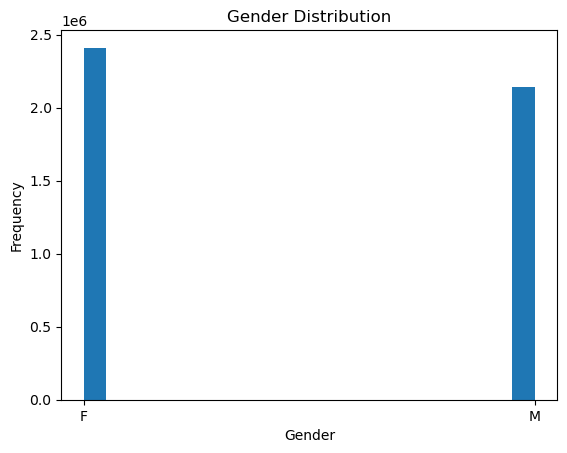

In [11]:
# Plot its distribution
data = sex_df.sort("Voters_Gender").toPandas()
plt.hist(data, bins=20)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')

## Education level

In [13]:
# drop Null values and show statistical description 
edu_df = df_need.select("CommercialData_Education").na.drop()
edu_df.groupBy("CommercialData_Education").count().show()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Grad Degree - Ext...|358435|
|    Grad Degree - Likely|324245|
|    Bach Degree - Ext...|596976|
|     HS Diploma - Likely|293945|
|    Less than HS Dipl...|   486|
|    Some College - Li...|410362|
|    Vocational Techni...|  3676|
|    Some College -Ext...|110743|
|    HS Diploma - Extr...|414355|
|    Less than HS Dipl...|114442|
|    Bach Degree - Likely|348668|
+------------------------+------+



## Household Income

In [19]:
# drop Null values and show statistical description 
hhincome_df = df_need.select("CommercialData_EstimatedHHIncomeAmount").na.drop()
hhincome_df = hhincome_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))

hhincome_df.describe(["CommercialData_EstimatedHHIncomeAmount"]).show()

+-------+--------------------------------------+
|summary|CommercialData_EstimatedHHIncomeAmount|
+-------+--------------------------------------+
|  count|                               4480735|
|   mean|                    119264.19954784204|
| stddev|                     66171.67859953281|
|    min|                                  6000|
|    max|                                351063|
+-------+--------------------------------------+



Text(0, 0.5, 'Frequency')

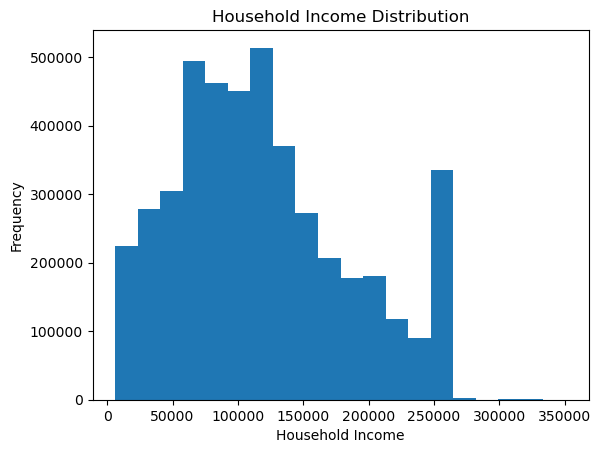

In [20]:
# Plot its distribution
data = hhincome_df.sort("CommercialData_EstimatedHHIncomeAmount").toPandas()
plt.hist(data, bins=20)
plt.title('Household Income Distribution')
plt.xlabel('Household Income')
plt.ylabel('Frequency')

# Relationship between education level and voter turnout

In [21]:
# voter turnout by education level
education_turnout_df = df_need.select("CommercialData_Education","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
education_turnout_df = education_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
education_turnout_count = education_turnout_df.groupBy("CommercialData_Education").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")
education_turnout_count.show(10)

+------------------------+-----------------+
|CommercialData_Education|            count|
+------------------------+-----------------+
|    Less than HS Dipl...|72.34989776480663|
|    Less than HS Dipl...|73.08230452674897|
|     HS Diploma - Likely|73.51963122352821|
|    Vocational Techni...|73.54053318824809|
|    HS Diploma - Extr...|73.74269889346093|
|    Some College - Li...|73.76983248936305|
|    Bach Degree - Likely|73.92255956956187|
|    Some College -Ext...|73.94918866203733|
|    Bach Degree - Ext...|74.13399868671438|
|    Grad Degree - Likely|74.40056438803991|
+------------------------+-----------------+
only showing top 10 rows



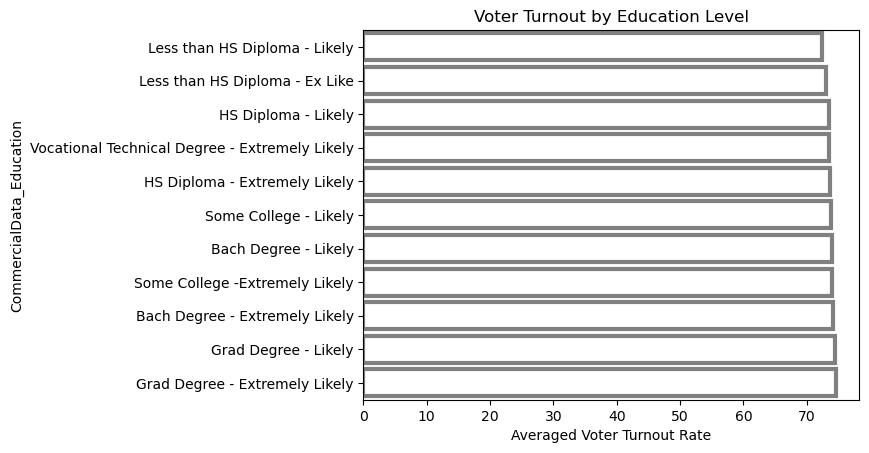

In [22]:
sns.barplot(data=education_turnout_count.toPandas(), x="count", y="CommercialData_Education",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Education Level")
plt.xlabel('Averaged Voter Turnout Rate')
plt.show()

# Relationship between HH income and voter turnout

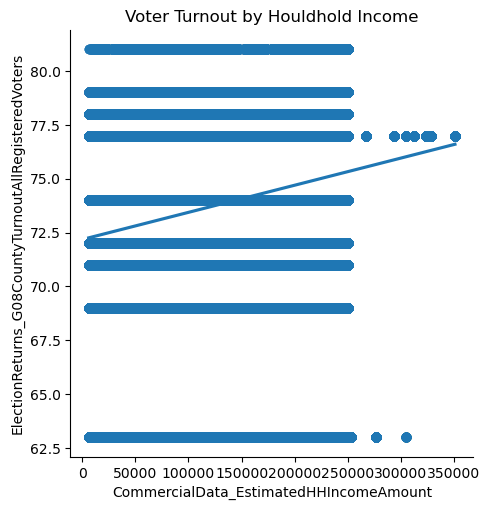

In [ ]:
# voter turnout by HH income
hhincome_turnout_df = df_need.select("CommercialData_EstimatedHHIncomeAmount","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
hhincome_turnout_df = hhincome_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.sort("CommercialData_EstimatedHHIncomeAmount")

# plot
sns.lmplot(data=hhincome_turnout_df.toPandas(),x="CommercialData_EstimatedHHIncomeAmount",y="ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
plt.title("Voter Turnout by Houldhold Income")
plt.show()

In [23]:
hhincome_turnout_df = df_need.select("CommercialData_EstimatedHHIncomeAmount","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
hhincome_turnout_df = hhincome_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
hhincome_turnout_count = hhincome_turnout_df.groupBy("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").agg(avg("CommercialData_EstimatedHHIncomeAmount").alias("count")).sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters")

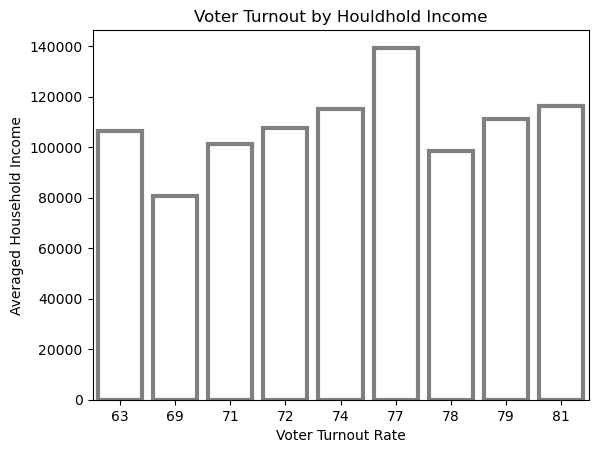

In [28]:
sns.barplot(data=hhincome_turnout_count.toPandas(), x="ElectionReturns_G08CountyTurnoutAllRegisteredVoters", y="count",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Houldhold Income")
plt.xlabel('Voter Turnout Rate')
plt.ylabel('Averaged Household Income')
plt.show()

# Relationship between age+gender with voter turnout

In [25]:
age_sex_turnout_df = df_need.select("Voters_Age","Voters_Gender","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
age_sex_turnout_df = age_sex_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
age_sex_turnout_count = age_sex_turnout_df.groupBy("Voters_Age","Voters_Gender").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")

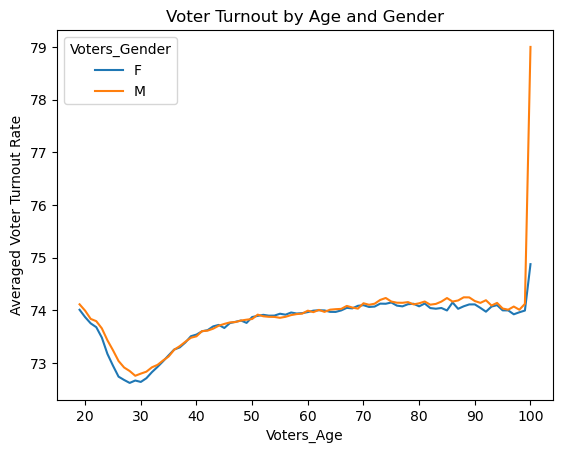

In [26]:
sns.lineplot(data=age_sex_turnout_count.toPandas(), x="Voters_Age", y="count", hue="Voters_Gender")
plt.title("Voter Turnout by Age and Gender")
plt.ylabel('Averaged Voter Turnout Rate')
plt.show()

# Model

In [8]:
# Import required libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

In [9]:
# Filter the data for Yavapai county
yavapai_data = df.filter(col("County") == "YAVAPAI")

In [10]:
# select some variables we are interested in from the data
spark.conf.set("spark.sql.debug.maxToStringFields", 1000) # this can solve your 1st bug
yavapai_data_need = yavapai_data.select("Voters_Age",
                                        "Voters_Gender",
                                        "CommercialData_Education",
                                        "EthnicGroups_EthnicGroup1Desc",
                                        "CommercialData_EstimatedHHIncomeAmount", 
                                        "CommercialData_EstHomeValue",
                                        "ElectionReturns_G18CountyTurnoutAllRegisteredVoters")
# Drop missing values 
yavapai_data_need = yavapai_data_need.na.drop()

yavapai_data_need.show(10)

+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_Education|EthnicGroups_EthnicGroup1Desc|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G18CountyTurnoutAllRegisteredVoters|
+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|        55|            F|     HS Diploma - Likely|                     European|                                $68000|                    $277133|                                                73%|
|        54|            M|     HS Diploma - Likely|                     European|                                $68000|                    $277133|                                                

In [77]:
# convert string columns to numeric 
yavapai_data_need = yavapai_data_need.withColumn("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
yavapai_data_need = yavapai_data_need.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
yavapai_data_need = yavapai_data_need.withColumn("CommercialData_EstHomeValue", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))").cast(IntegerType()))
yavapai_data_need = yavapai_data_need.withColumn("Voters_Age", yavapai_data_need["Voters_Age"].cast(IntegerType()))

yavapai_data_need.show(10)

+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_Education|EthnicGroups_EthnicGroup1Desc|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G18CountyTurnoutAllRegisteredVoters|
+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|        55|            F|     HS Diploma - Likely|                     European|                                 68000|                     277133|                                                 73|
|        54|            M|     HS Diploma - Likely|                     European|                                 68000|                     277133|                                                

In [78]:
yavapai_data_need.printSchema()

root
 |-- Voters_Age: integer (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_EstimatedHHIncomeAmount: integer (nullable = true)
 |-- CommercialData_EstHomeValue: integer (nullable = true)
 |-- ElectionReturns_G18CountyTurnoutAllRegisteredVoters: integer (nullable = true)



In [79]:
# Create string indexer and one-hot encoder for categorical columns
ethnic_group_indexer = StringIndexer(inputCol="EthnicGroups_EthnicGroup1Desc", outputCol="ethnic_group_index")
gender_indexer = StringIndexer(inputCol="Voters_Gender", outputCol="gender_index")
education_indexer = StringIndexer(inputCol="CommercialData_Education", outputCol="education_index")


ethnic_group_encoder = OneHotEncoder(inputCol="ethnic_group_index", outputCol="ethnic_group_vec")
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_vec")
education_encoder = OneHotEncoder(inputCol="education_index", outputCol="education_vec")

In [80]:
# Create vector assembler to combine all features
assembler = VectorAssembler(inputCols=["CommercialData_EstimatedHHIncomeAmount", "CommercialData_EstHomeValue", "Voters_Age",
                                       "ethnic_group_vec", "gender_vec", "education_vec"],
                            outputCol="features")

In [81]:
# Create random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters")

In [82]:
# Create a pipeline for all transformations and the model
pipeline = Pipeline(stages=[ethnic_group_indexer, gender_indexer, education_indexer,
                            ethnic_group_encoder, gender_encoder, education_encoder,
                            assembler, rf])

In [83]:
# Split the data into training and testing sets
(train_data, test_data) = yavapai_data_need.randomSplit([0.7, 0.3], seed=100)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

In [89]:
# Make predictions on the testing data
predictions = model.transform(test_data)

In [94]:
# Evaluate the performance of the model on the test data
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
evaluator = RegressionEvaluator(labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"RMSE on the test data: {rmse}")

RMSE on the test data: 0.0


In [95]:
# Evaluate the performance of the model
evaluator = MulticlassClassificationEvaluator(labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Accuracy = 1


# County-level model

In [19]:
# convert string columns to numeric 
df = df.withColumn("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
df = df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
df = df.withColumn("CommercialData_EstHomeValue", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))").cast(IntegerType()))
df = df.withColumn("Voters_Age", yavapai_data_need["Voters_Age"].cast(IntegerType()))

In [22]:
counties_df = df.select(
    "County", "Voters_Age", "CommercialData_EstimatedHHIncomeAmount", 
    "CommercialData_EstHomeValue",
    "ElectionReturns_G18CountyTurnoutAllRegisteredVoters"
).groupBy("County").agg(
    mean("Voters_Age").alias("Voters_Age"),
    mean("CommercialData_EstimatedHHIncomeAmount").alias("CommercialData_EstimatedHHIncomeAmount"),
    mean("CommercialData_EstHomeValue").alias("CommercialData_EstHomeValue"),
    mean("ElectionReturns_G18CountyTurnoutAllRegisteredVoters").alias("ElectionReturns_G18CountyTurnoutAllRegisteredVoters")
)

In [23]:
counties_df.show()

+----------+------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|    County|        Voters_Age|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G18CountyTurnoutAllRegisteredVoters|
+----------+------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|      YUMA| 49.04563866871799|                     66823.36766988254|          197652.1185163167|                                               43.0|
|  COCONINO| 47.00760157273919|                      89504.1885411113|         363691.40542001755|                                               61.0|
|   COCHISE|53.934794704900426|                      73413.9386718803|         186031.02946930623|                                               60.0|
|  GREENLEE| 48.65705869976857|                     79394.65979125249|         101277.09937038

In [24]:
# Create vector assembler to combine all features
assembler = VectorAssembler(
    inputCols=[
        "Voters_Age", "CommercialData_EstimatedHHIncomeAmount", 
        "CommercialData_EstHomeValue"
    ],
    outputCol="features"
)

In [26]:
# Create random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters")

# Create a pipeline for all transformations and the model
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
(train_data, test_data) = counties_df.randomSplit([0.7, 0.3], seed=100)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

23/03/16 07:38:03 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 9 (= number of training instances)


In [27]:
# Evaluate the performance of the model on the test data
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

evaluator = RegressionEvaluator(
    labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

print(f"RMSE on the test data: {rmse}")

RMSE on the test data: 7.939038564796956
